In [26]:
import pandas as pd 
import geopandas as gpd
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100

In [68]:
# load geojson data as geodataframe for full postal code shapes 
# (https://www.suche-postleitzahl.org/downloads)
# possible postal codes: 1 digit: "1stellig", 2 digits: "2stellig", 
#                        3 digits: "3stellig", 5 digits: "5stellig", 
#                    post codes to states mapping: "zuordnung_plz_ort"

germany_geo_url = 'https://downloads.suche-postleitzahl.org/v2/public/'  
germany_geojson = gpd.read_file(germany_geo_url + 'plz-5stellig.geojson')
germany_geojson = germany_geojson[['plz','geometry']] 
# convert plz to integer
germany_geojson['plz'] = germany_geojson['plz'].astype(str).astype(int)

# load postal code to state mapping
df_post_codes = pd.read_csv(germany_geo_url + 'zuordnung_plz_ort.csv')
df_post_codes = df_post_codes[['plz','bundesland']]

# load covid data (https://impfdashboard.de/daten)
# data updated daily at 10am
# possible data: 
# germany_vaccinations_timeseries_v3.tsv
# germany_deliveries_timeseries_v2.tsv
# vaccinations_quotes_v1.tsv
# metadata.json
covid_url = 'https://impfdashboard.de/static/data/'
df_covid_vacc = pd.read_table(covid_url + 'vaccinations_quotes_v1.tsv')

In [69]:
# inspect data

# df_covid_vacc.head(10)
# print(df_covid_vacc.dropna(axis=1))
df_covid_vacc = df_covid_vacc.dropna(axis=1)

# create new data frame with all relevant information
df_germany_covid = df_post_codes.copy()

In [72]:
df_covid_vacc.head(3)

,date,region,impfungen_min1,impfungen_gi,impfungen_boost1,impfungen_boost2,impfquote_min1,impfquote_5bis11_min1,impfquote_12bis17_min1,impfquote_18bis59_min1,...,impfquote_boost1,impfquote_12bis17_boost1,impfquote_18bis59_boost1,impfquote_18plus_boost1,impfquote_60plus_boost1,impfquote_boost2,impfquote_12bis17_boost2,impfquote_18bis59_boost2,impfquote_18plus_boost2,impfquote_60plus_boost2
0,2022-07-12,DE-BUND,64714929,63368741,51338510,6096088,77.8,22.4,74.3,83.9,...,61.7,30.5,64.7,71.9,85.6,7.3,0.5,2.2,8.8,21.0
1,2022-07-12,DE-SH,2353526,2322260,2030118,427177,80.9,30.9,93.6,84.7,...,69.7,46.7,73.3,80.0,91.9,14.7,0.6,3.8,17.5,41.6
2,2022-07-12,DE-HH,1603966,1560357,1213544,158174,86.6,29.8,80.6,96.1,...,65.5,28.5,71.3,77.0,91.4,8.5,0.7,3.1,10.2,28.1


In [75]:
# full state names (https://www.datenportal.bmbf.de/portal/de/G122.html)
state_name_code = {
    'BW':'Baden-Württemberg',
    'BY':'Bayern',
    'BE':'Berlin',
    'BB':'Brandenburg',
    'HB':'Bremen',
    'HH':'Hamburg',
    'HE':'Hessen',
    'MV':'Mecklenburg-Vorpommern',
    'NI':'Niedersachsen',
    'NW':'Nordrhein-Westfalen',
    'RP':'Rheinland-Pfalz',
    'SL':'Saarland',
    'SN':'Sachsen',
    'ST':'Sachsen-Anhalt',
    'SH':'Schleswig-Holstein',
    'TH':'Thüringen'
}

# enter different numbers of vaccinations & change labels of states in covid df

# covid vaccination data of interest
vacc_type_code = {
    'impfungen_min1':'num_first_vacc',
    'impfungen_gi':'num_full_vacc',
    'impfungen_boost1':'num_boost1_vacc',
    'impfungen_boost2':'num_boost2_vacc',
    'impfquote_min1':'perc_first_vacc',
    'impfquote_boost1':'perc_boost1_vacc',
    'impfquote_boost2':'perc_boost2_vacc',
}

for vacc in vacc_type_code: 
    df_germany_covid[vacc_type_code[vacc]] = ""
    for state in state_name_code:        
        vacc_val = int(df_covid_vacc.loc[df_covid_vacc.region == 'DE-' + state, vacc])
        df_germany_covid.loc[df_germany_covid.bundesland == state_name_code[state], vacc_type_code[vacc]] = vacc_val

In [76]:
df_germany_covid.head(3)

,plz,bundesland,num_first_vacc,num_full_vacc,num_boost1_vacc,num_boost2_vacc,perc_first_vacc,perc_boost1_vacc,perc_boost2_vacc
0,78267,Baden-Württemberg,8396692,8262021,6731090,532648,75,60,4
1,54298,Rheinland-Pfalz,3236755,3098192,2582438,318195,79,63,7
2,52062,Nordrhein-Westfalen,14637594,14218994,11673391,1857530,81,65,10


In [77]:
# merge with geo data
df_germany_covid = pd.merge(left=germany_geojson, right=df_germany_covid, on='plz', how='inner')
df_germany_covid.head(3)

,plz,geometry,bundesland,num_first_vacc,num_full_vacc,num_boost1_vacc,num_boost2_vacc,perc_first_vacc,perc_boost1_vacc,perc_boost2_vacc
0,81248,"POLYGON ((11.3946783 48.1472871, 11.3948446 48...",Bayern,9894217,9876373,7696201,621504,75,58,4
1,60315,"POLYGON ((8.672536600000001 50.1126399, 8.6736...",Hessen,4925539,4732042,3786451,436243,78,60,6
2,24988,"POLYGON ((9.365855 54.6999426, 9.368257 54.696...",Schleswig-Holstein,2353526,2322260,2030118,427177,80,69,14


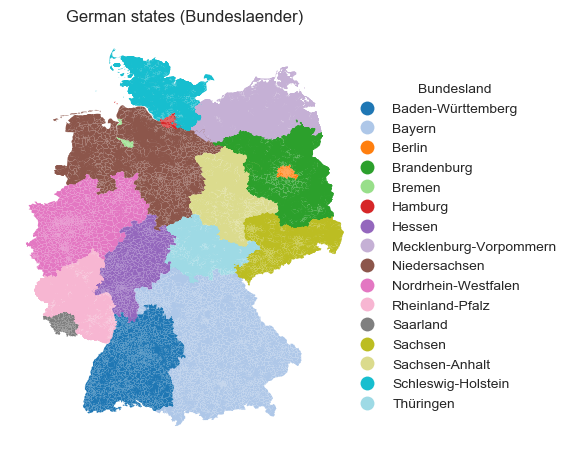

In [88]:
# plot german states overview
fig, ax = plt.subplots()

df_germany_covid.plot(
    ax=ax,     
    column='bundesland', 
    categorical=True, 
    legend=True, 
    legend_kwds={'title':'Bundesland', 'bbox_to_anchor': (1.6, .9)},
    cmap='tab20',
    alpha=1
)

ax.set(
    title='German states (Bundeslaender)', 
    aspect=1.4, 
    facecolor='white'
)

ax.tick_params(
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False,
    labelright=False,
    grid_alpha=0
)

plt.show()

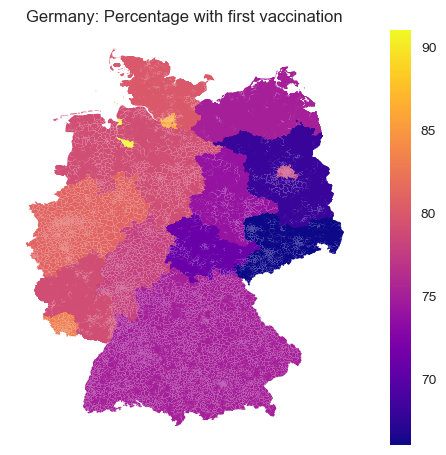

In [93]:
#ax = df_germany_covid.plot(column='bundesland', edgecolor='black')
fig, ax = plt.subplots()

df_germany_covid.plot(
    ax=ax,     
    column='perc_first_vacc', 
    categorical=False, 
    legend=True, 
    cmap='plasma',
    alpha=1
)

ax.set(
    title='Germany: Percentage with first vaccination', 
    aspect=1.4, 
    facecolor='white'
)

ax.tick_params(
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False,
    labelright=False,
    grid_alpha=0
)

plt.show()

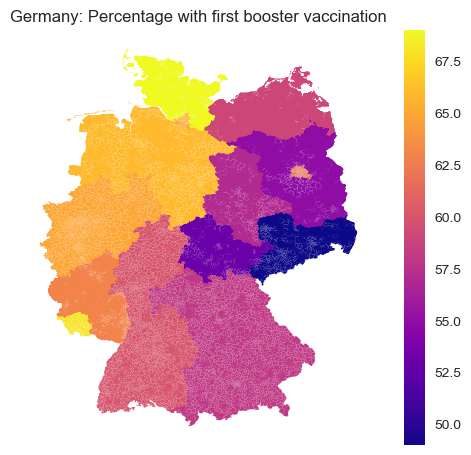

In [94]:
fig, ax = plt.subplots()

df_germany_covid.plot(
    ax=ax,     
    column='perc_boost1_vacc', 
    categorical=False, 
    legend=True, 
    cmap='plasma',
    alpha=1
)

ax.set(
    title='Germany: Percentage with first booster vaccination', 
    aspect=1.4, 
    facecolor='white'
)

ax.tick_params(
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False,
    labelright=False,
    grid_alpha=0
)

plt.show()

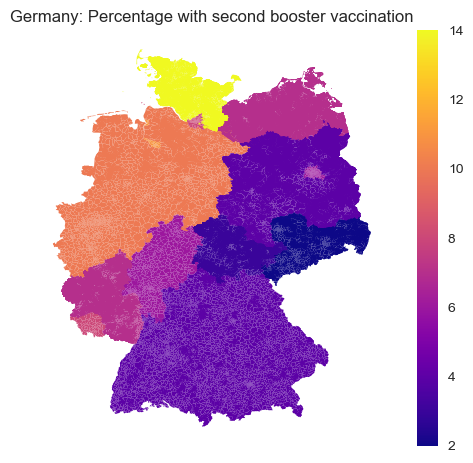

In [95]:
fig, ax = plt.subplots()

df_germany_covid.plot(
    ax=ax,                  
    column='perc_boost2_vacc', 
    categorical=False, 
    legend=True, 
    cmap='plasma',
    alpha=1
)

ax.set(
    title='Germany: Percentage with second booster vaccination', 
    aspect=1.4, 
    facecolor='white'
)

ax.tick_params(
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False,
    labelright=False,
    grid_alpha=0
)

plt.show()